In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import datetime
from datetime import datetime, timedelta, date
import pickle
import warnings

#settings
warnings.filterwarnings("ignore")

appearances_df = pd.read_csv("../raw_data/appearances.csv")
clubs_df = pd.read_csv("../raw_data/clubs.csv")
games_df = pd.read_csv("../raw_data/games.csv")
players_df = pd.read_csv("../raw_data/players.csv")



def players_df_preproc(players_df):
    #add year to game valuations
    now = datetime.now()
    players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])
    players_df = players_df[players_df['date_of_birth'].isnull() == False]
    players_df['age'] = (now - players_df['date_of_birth']).apply(lambda x: x.days) / 365.25
    players_df['age'] = players_df['age'].round().astype(int) 

    # Calculate the contract remaining of each player
    players_df['contract_expiration_date'] = pd.to_datetime(players_df['contract_expiration_date'])
    players_df = players_df[players_df['contract_expiration_date'].isnull() == False]
    players_df['term_days_remaining'] = (players_df['contract_expiration_date']- now).apply(lambda x: x.days) 
    return players_df

def appearances_df_preproc(appearances_df):
    # add year to player appearances
    appearances_df['datetime']=pd.to_datetime(appearances_df['date'], format="%Y-%m-%d")
    appearances_df['year']=appearances_df['datetime'].dt.year
    appearances_df = appearances_df[(appearances_df.year > 2004 ) & (appearances_df.year < 2023 )]
    return appearances_df
"""
def games_and_appearances_df_preproc(games_df,appearances_df):
    games_df['datetime']=pd.to_datetime(games_df['date'], format="%Y-%m-%d")
    games_df['year']=games_df['datetime'].dt.year
    games_df = games_df[(games_df.year > 2004 ) & (games_df.year < 2023 )]
    games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
    return games_and_appearances_df

def feature_encode(df,column):
    dummies=pd.get_dummies(df[column], prefix_sep='_') 
    df = pd.concat([df, dummies], axis=1)
    return df
    """

'\ndef games_and_appearances_df_preproc(games_df,appearances_df):\n    games_df[\'datetime\']=pd.to_datetime(games_df[\'date\'], format="%Y-%m-%d")\n    games_df[\'year\']=games_df[\'datetime\'].dt.year\n    games_df = games_df[(games_df.year > 2004 ) & (games_df.year < 2023 )]\n    games_and_appearances_df = appearances_df.merge(games_df, on=[\'game_id\'], how=\'left\')\n    return games_and_appearances_df\n\ndef feature_encode(df,column):\n    dummies=pd.get_dummies(df[column], prefix_sep=\'_\') \n    df = pd.concat([df, dummies], axis=1)\n    return df\n    '

In [2]:
def games_and_appearances_df_preproc(games_df,appearances_df,clubs_df):
    games_df['datetime']=pd.to_datetime(games_df['date'], format="%Y-%m-%d")
    games_df['year']=games_df['datetime'].dt.year
    games_df = games_df[(games_df.year > 2004 ) & (games_df.year < 2023 )]
    games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
    
    # here we impute the missing values with the minimum value of the corresponding league 
    # get the minimum value of the 'Domestic League' column
    min_value = clubs_df.groupby('domestic_competition_id')['total_market_value'].min()
        
    # fill missing values in 'Market Value' column with the minimum value of the 'Domestic League' column
    clubs_df['total_market_value'] = clubs_df.apply(lambda x: min_value[x['domestic_competition_id']] if pd.isnull(x['total_market_value']) else x['total_market_value'], axis=1)
    
    table_df = games_and_appearances_df
    
    # Join the tables on the home and away club IDs
    table_df = table_df.merge(clubs_df[['club_id', 'total_market_value']], 
                            how='left', 
                            left_on='home_club_id', 
                            right_on='club_id')

    table_df = table_df.merge(clubs_df[['club_id', 'total_market_value']], 
                            how='left', 
                            left_on='away_club_id', 
                            right_on='club_id',
                            suffixes=('_home', '_away'))

    # Rename the columns to reflect the market value data
    table_df = table_df.rename(columns={'market_value_home': 'home_club_market_value',
                                        'market_value_away': 'away_club_market_value'})

    # Drop the redundant club_id columns
    table_df = table_df.drop(['club_id_home', 'club_id_away'], axis=1)
    
    games_and_appearances_df = table_df
    
    games_and_appearances_df.dropna(inplace=True)
    
    
    return games_and_appearances_df

In [3]:
def player_stats(player_id, season, games_and_appearances_df):
    #create a function to collate player stats
    df = games_and_appearances_df[games_and_appearances_df['player_id'] == player_id]
    df =  df[df['season'] == season]    
    if (df.shape[0] == 0):
        Out = [(np.nan, season,0,0,0,0,0,0,0,0,0,0,0,0)]
        out_df = pd.DataFrame(data = Out, columns = ['player_id','season','goals','games',
                                                     'assists','minutes_played','goals_for',
                                                     'goals_against','clean_sheet',
                                                     'yellow_cards', 'red_cards','value_goals_for','value_goals_against','value_clean_sheet'])
        return out_df    
    else:       
        df["goals_for"] = df.apply(lambda row: row['home_club_goals'] if row['home_club_id'] == row['player_club_id'] 
            else row['away_club_goals'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df["goals_against"] = df.apply(lambda row: row['away_club_goals'] if row['home_club_id'] == row['player_club_id'] 
            else row['home_club_goals'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df['clean_sheet'] = df.apply(lambda row: 1 if row['goals_against'] == 0
            else np.nan if row['goals_against'] > 0
            else np.nan, axis=1)
        
        #engineering 
        df["value_goals_for"] = df.apply(lambda row: row['goals']*row['total_market_value_away'] if row['home_club_id'] == row['player_club_id'] 
            else row['goals']*row['total_market_value_home'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df["value_goals_against"] = df.apply(lambda row: row['away_club_goals']/row['total_market_value_away'] if row['home_club_id'] == row['player_club_id'] 
            else row['home_club_goals']/row['total_market_value_home'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df['value_clean_sheet'] = df.apply(lambda row: row['total_market_value_away'] if row['goals_against'] == 0 and row['home_club_id'] == row['player_club_id']
            else row['total_market_value_home'] if row['goals_against'] == 0 and row['away_club_id'] == row['player_club_id']
            else 0 if row['goals_against'] > 0
            else np.nan, axis=1)
        
        
        #print(df["value_goals_for"])
        
        df = df.groupby(['player_id',"season"],as_index=False).agg({'goals': 'sum', 'game_id': 'nunique', 
                                                                    'assists': 'sum', 'minutes_played' : 'sum', 'goals_for' : 'sum',
                                                                    'goals_against' : 'sum', 'clean_sheet' : 'sum','yellow_cards':'sum', 
                                                                    'red_cards':'sum',
                                                                    'value_goals_for':'sum','value_goals_against':'sum','value_clean_sheet':'sum'})
        out_df = df.rename(columns={'game_id': 'games'})
        return out_df


In [4]:
# preprocessing function to return a dataframe
def data_cleaning(clubs_df,players_df,games_and_appearances_df):
    
    merged_players_df=players_df.drop(['current_club_id', 'city_of_birth', 'date_of_birth','first_name', 
                                       'last_name', 'player_code', 'image_url', 'url'], axis=1)
    merged_players_df = merged_players_df.reindex(columns = merged_players_df.columns.tolist() + 
                                                  ['club_value','squad_size','goals','goals_2022','games_2022',
                                                    'assists_2022','minutes_played_2022','goals_against_2022',
                                                    'goals_for_2022','clean_sheet_2022',
                                                    'value_goals_for_2022', 'value_goals_against_2022','value_clean_sheet_2022'])
    
    for player_id in merged_players_df.player_id.unique():
        club_id = players_df.current_club_id[(players_df.player_id==player_id)]
        try:
            merged_players_df.club_value[(players_df.player_id==player_id)]=int(clubs_df.total_market_value[(clubs_df.club_id==int(club_id))])
        except:
            merged_players_df.club_value[(players_df.player_id==player_id)]='NaN'  
        merged_players_df.squad_size[(players_df.player_id==player_id)]=int((clubs_df.squad_size[(clubs_df.club_id==int(club_id))]))

    columns=['player_id','games_2022','minutes_played_2022','goals_2022','assists_2022','goals_against_2022','goals_for_2022',
             'clean_sheet_2022','name','position','sub_position','last_season','foot','height_in_cm','age','country_of_citizenship',
             'country_of_birth','current_club_name','club_value','squad_size','current_club_domestic_competition_id','agent_name',
             'contract_expiration_date','term_days_remaining','market_value_in_eur','highest_market_value_in_eur',
             'value_goals_for_2022','value_goals_against_2022','value_clean_sheet_2022']
    merged_players_df=merged_players_df[columns] 

    #iterate through players
    for index in merged_players_df.index:
        id = merged_players_df.loc[index][0]
        name = merged_players_df.loc[index][1]
        
        season = 2022
        stats = player_stats(id, season, games_and_appearances_df)
  
        merged_players_df.at[index,'games_{}'.format(season)]= stats['games'][0]
        merged_players_df.at[index,'goals_{}'.format(season)]= stats['goals'][0]
        merged_players_df.at[index,'assists_{}'.format(season)]= stats['assists'][0]
        merged_players_df.at[index,'minutes_played_{}'.format(season)]= stats['minutes_played'][0]
        merged_players_df.at[index,'goals_for_{}'.format(season)]= stats['goals_for'][0]
        merged_players_df.at[index,'goals_against_{}'.format(season)]= stats['goals_against'][0]
        merged_players_df.at[index,'clean_sheet_{}'.format(season)]= stats['clean_sheet'][0]
        merged_players_df.at[index,'yellow_cards_{}'.format(season)]= stats['yellow_cards'][0]
        merged_players_df.at[index,'red_cards_{}'.format(season)]= stats['red_cards'][0]
        merged_players_df.at[index,'value_goals_for_{}'.format(season)]= stats['value_goals_for'][0]
        merged_players_df.at[index,'value_goals_against_{}'.format(season)]= stats['value_goals_against'][0]
        merged_players_df.at[index,'value_clean_sheet_{}'.format(season)]= stats['value_clean_sheet'][0]


    #drop nan
    merged_players_df0=merged_players_df.dropna(subset=['market_value_in_eur'])
    
    return merged_players_df0

In [5]:
players_df = players_df[players_df['last_season']==2022]
players_df = players_df[players_df['position']=='Attack']

In [6]:
# test above functions

players_df = players_df_preproc(players_df)
appearances_df = appearances_df_preproc(appearances_df)
games_and_appearances_df = games_and_appearances_df_preproc(games_df,appearances_df,clubs_df)
df_cleaned = data_cleaning(clubs_df,players_df,games_and_appearances_df)

In [7]:
df_cleaned.head()

,player_id,games_2022,minutes_played_2022,goals_2022,assists_2022,goals_against_2022,goals_for_2022,clean_sheet_2022,name,position,...,agent_name,contract_expiration_date,term_days_remaining,market_value_in_eur,highest_market_value_in_eur,value_goals_for_2022,value_goals_against_2022,value_clean_sheet_2022,yellow_cards_2022,red_cards_2022
21969,751084,11.0,367.0,0.0,0.0,25.0,5.0,0.0,Matvey Ivakhnov,Attack,...,NaN,2023-06-30,93,100000.0,100000.0,0.00,9.920635,0.00,3.0,0.0
21970,79642,14.0,1175.0,1.0,1.0,14.0,17.0,5.0,Shinji Okazaki,Attack,...,PRO Profil GmbH,2023-06-30,93,250000.0,10000000.0,4.21,3.325416,21.05,1.0,0.0
21971,217923,17.0,1357.0,1.0,1.0,29.0,14.0,3.0,Khyzyr Appaev,Attack,...,NaN,2023-06-30,93,300000.0,700000.0,2.52,11.507937,7.56,3.0,0.0
21972,525692,20.0,944.0,3.0,2.0,37.0,16.0,3.0,Georgiy Gongadze,Attack,...,NaN,2024-06-30,459,500000.0,500000.0,7.56,14.682540,7.56,3.0,0.0
21973,237623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Oleksandr Filippov,Attack,...,ProStar,2023-06-30,93,250000.0,1300000.0,0.00,0.000000,0.00,0.0,0.0


In [8]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2087 entries, 21969 to 28487
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   player_id                             2087 non-null   int64         
 1   games_2022                            2087 non-null   float64       
 2   minutes_played_2022                   2087 non-null   float64       
 3   goals_2022                            2087 non-null   float64       
 4   assists_2022                          2087 non-null   float64       
 5   goals_against_2022                    2087 non-null   float64       
 6   goals_for_2022                        2087 non-null   float64       
 7   clean_sheet_2022                      2087 non-null   float64       
 8   name                                  2087 non-null   object        
 9   position                              2087 non-null   object        


In [9]:
df_cleaned.describe()

,player_id,games_2022,minutes_played_2022,goals_2022,assists_2022,goals_against_2022,goals_for_2022,clean_sheet_2022,last_season,height_in_cm,...,club_value,squad_size,term_days_remaining,market_value_in_eur,highest_market_value_in_eur,value_goals_for_2022,value_goals_against_2022,value_clean_sheet_2022,yellow_cards_2022,red_cards_2022
count,2.087000e+03,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.0,2087.000000,...,2087.000000,2087.000000,2087.000000,2.087000e+03,2.085000e+03,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000
mean,3.896304e+05,10.026354,555.397221,1.783421,1.091998,14.206517,14.603737,2.715381,2022.0,176.114518,...,4.132726,27.532343,632.982750,6.425994e+06,1.080746e+07,9.140810,4.811797,13.621308,1.172496,0.035937
std,2.267819e+05,6.130709,458.016705,2.547921,1.626473,9.812870,11.922354,2.519810,0.0,26.969903,...,3.203563,3.128869,501.170235,1.364061e+07,2.034873e+07,18.070541,4.828205,19.410957,1.411482,0.188734
min,3.455000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022.0,0.000000,...,1.000000,7.000000,63.000000,2.500000e+04,2.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.108385e+05,5.000000,120.500000,0.000000,0.000000,6.000000,5.000000,1.000000,2022.0,175.000000,...,1.000000,25.000000,93.000000,5.000000e+05,7.500000e+05,0.000000,1.306519,1.100000,0.000000,0.000000
50%,3.578850e+05,11.000000,491.000000,1.000000,0.000000,15.000000,13.000000,2.000000,2022.0,180.000000,...,4.000000,27.000000,459.000000,1.500000e+06,3.000000e+06,2.480000,3.345725,7.560000,1.000000,0.000000
75%,5.520580e+05,15.000000,914.500000,3.000000,2.000000,22.000000,21.000000,4.000000,2022.0,185.000000,...,6.000000,30.000000,916.000000,6.000000e+06,1.200000e+07,10.760000,6.820345,17.920000,2.000000,0.000000
max,1.059630e+06,25.000000,2094.000000,27.000000,15.000000,51.000000,63.000000,12.000000,2022.0,202.000000,...,12.000000,36.000000,3015.000000,1.800000e+08,2.000000e+08,299.940000,27.272727,208.270000,8.000000,2.000000


In [10]:
import seaborn as sns

<Axes: xlabel='value_goals_for_2022', ylabel='Count'>

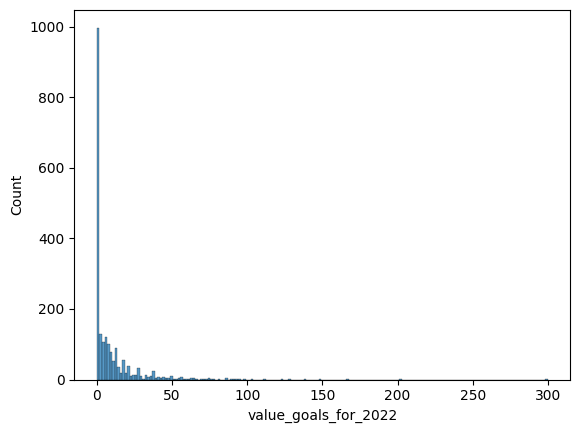

In [11]:
sns.histplot(df_cleaned["value_goals_for_2022"])

In [12]:
df_cleaned.to_pickle('attackers_more_features_df.pkl')

In [13]:
df_cleaned.columns

Index(['player_id', 'games_2022', 'minutes_played_2022', 'goals_2022',
       'assists_2022', 'goals_against_2022', 'goals_for_2022',
       'clean_sheet_2022', 'name', 'position', 'sub_position', 'last_season',
       'foot', 'height_in_cm', 'age', 'country_of_citizenship',
       'country_of_birth', 'current_club_name', 'club_value', 'squad_size',
       'current_club_domestic_competition_id', 'agent_name',
       'contract_expiration_date', 'term_days_remaining',
       'market_value_in_eur', 'highest_market_value_in_eur',
       'value_goals_for_2022', 'value_goals_against_2022',
       'value_clean_sheet_2022', 'yellow_cards_2022', 'red_cards_2022'],
      dtype='object')